In [112]:
import asyncio
import aiohttp
import requests
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import string
import concurrent.futures
num_requests =10000

In [110]:
### Initialization of servers ####
Payload_Json= {
    "N":6,
    "schema":{"columns":["Stud_id","Stud_name","Stud_marks"],
    "dtypes":["Number","String","String"]},

    "shards":[{"Stud_id_low":0, "Shard_id": "sh1", "Shard_size":4096},
    {"Stud_id_low":4096, "Shard_id": "sh2", "Shard_size":4096},
    {"Stud_id_low":8192, "Shard_id": "sh3", "Shard_size":4096},
    {"Stud_id_low":12288, "Shard_id": "sh4", "Shard_size":4096}],
    
    "servers":{
    "Server1":["sh3","sh4"],
    "Server2":["sh2","sh3"],
    "Server3":["sh1","sh3"],
    "Server4":["sh4","sh2"],
    "Server5":["sh1","sh4"],
    "Server6":["sh3","sh2"]}
    }
init_start = time.perf_counter()
res = requests.post("http://10.171.9.221:5000/init",json=Payload_Json).json()
print(res)
init_time = time.perf_counter()-init_start
print("Request completed in {0:.4f} seconds".format(init_time))

{'message': 'Configured Database', 'status': 'success'}
Request completed in 23.0768 seconds


In [111]:
######## Check Status ################
res = requests.get("http://10.171.9.221:5000/status").json()
res

{'N': 6,
 'schema': {'columns': ['Stud_id', 'Stud_name', 'Stud_marks'],
  'dtypes': ['Number', 'String', 'String']},
 'servers': {'Server1': ['sh3', 'sh4'],
  'Server2': ['sh2', 'sh3'],
  'Server3': ['sh1', 'sh3'],
  'Server4': ['sh4', 'sh2'],
  'Server5': ['sh1', 'sh4'],
  'Server6': ['sh3', 'sh2']},
 'shards': [{'Shard_id': 'sh1', 'Shard_size': 4096, 'Stud_id_low': 0},
  {'Shard_id': 'sh2', 'Shard_size': 4096, 'Stud_id_low': 4096},
  {'Shard_id': 'sh3', 'Shard_size': 4096, 'Stud_id_low': 8192},
  {'Shard_id': 'sh4', 'Shard_size': 4096, 'Stud_id_low': 12288}]}

In [113]:

####### 10000 request for write ###################
def generate_random_string():
    letters = string.ascii_uppercase  # Get all lowercase letters
    return ''.join(random.choices(letters, k=random.randint(3,6)))  


write_time = []
def writeRequest(id):
    url = "http://10.171.9.221:5000/write"
    write_Json = {"data":[{"Stud_id":id,"Stud_name":f"{str(generate_random_string())}","Stud_marks":random.randint(0,100)}]}
    start = time.time()
    requestRes = requests.post(url,json=write_Json)
    write_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in write")



### Write Operation

In [114]:
total_start_time=time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    write_tasks=[executor.submit(writeRequest(_)) for _ in range(num_requests)]
    concurrent.futures.wait(write_tasks)

print(f"Total time taken: {time.time() - total_start_time} secs")

Total time taken: 184.91156578063965 secs


In [102]:
# ####### 10000 request for write ###################
# def generate_random_string():
#     letters = string.ascii_uppercase  # Get all lowercase letters
#     return ''.join(random.choices(letters, k=random.randint(3,6)))  
# write_time = []

# for _ in range(num_requests):
#     url = "http://10.171.9.221:5000/read"
#     write_Json = {"data":[{"Stud_id":_,"Stud_name":f"{str(generate_random_string())}","Stud_marks":random.randint(0,100)}]}
#     # print(write_Json)
#     start = time.time()
#     requestRes = requests.post(url,json=write_Json)
#     print(str(requestRes))
#     write_time.append(time.time() - start)
#     if requestRes.status_code != 200:
#         print(f"Error {requestRes.status_code} in Write")

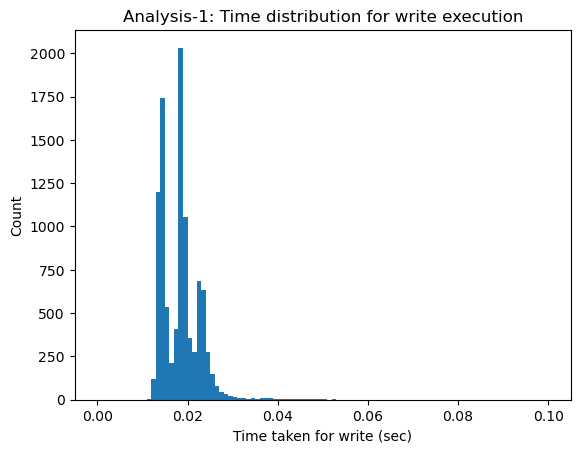

In [116]:
plt.hist(write_time, 100, (0,.1))
plt.xlabel("Time taken for write (sec)")
plt.ylabel("Count")
plt.title("Analysis-1: Time distribution for write execution")
plt.savefig("./results/Assign2_A1_Write.jpg")
plt.show()

### Read Operation

In [61]:
# read_time = []

# def readRequest():
#     url = "http://10.171.9.221:5000/read"
#     low =  random.randint(0,16383)
#     read_Json = {"Stud_id" : {"low":low,"high":low+10}}
#     start = time.time()
#     requestRes = requests.post(url,json=read_Json)
#     print(str(requestRes))
#     read_time.append(time.time() - start)
#     if requestRes.status_code != 200:
#         print(f"Error {requestRes.status_code} in Read")

In [62]:
# url = "http://10.171.9.221:5000/read"
# read_Json = {"Stud_id" : {"low":1000,"high":10000}}
# requestRes = requests.post(url,json=read_Json)

In [63]:
# requestRes

In [64]:
# total_start_time=time.time()
# with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
#     read_tasks=[executor.submit(readRequest) for _ in range(num_requests)]
#     concurrent.futures.wait(read_tasks)

# print(f"Total time taken: {time.time() - total_start_time} secs")

<Response [200]><Response [500]>
Error 500 in Read

<Response [200]>
<Response [200]>
<Response [500]>
Error 500 in Read
Total time taken: 11.829792737960815 secs


In [117]:
read_time = []

for _ in range(num_requests):
    url = "http://10.171.9.221:5000/read"
    low =  random.randint(0,16383)
    read_Json = {"Stud_id" : {"low":low,"high":low+10}}
    start = time.time()
    requestRes = requests.post(url,json=read_Json)
    # print(str(requestRes))
    read_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in Read")

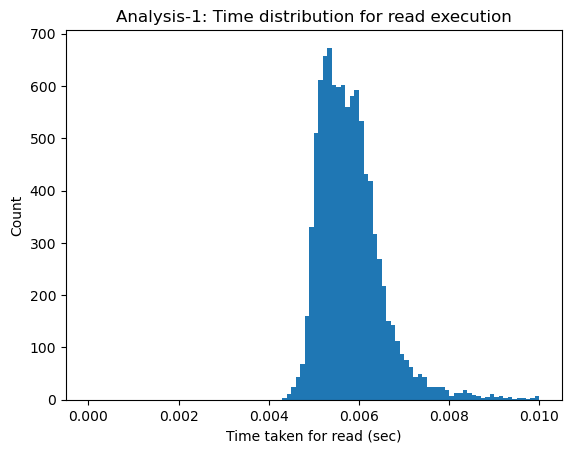

In [119]:
plt.hist(read_time, 100, (0,.01))
plt.xlabel("Time taken for read (sec)")
plt.ylabel("Count")
plt.title("Analysis-1: Time distribution for read execution")
plt.savefig("./results/Assign2_A1_Read.jpg")
plt.show()

In [108]:
Payload_Json = {
    "n": 1,
    "servers": ["Server2"]
}
# Payload_Json = {
#     "n": 6,
#     "servers": ["Server1", "Server2", "Server3", "Server4", "Server5","Server6"],
# }
url = "http://10.171.9.221:5000/rm"
res = requests.delete(url, json=Payload_Json)
res.json()

{'message': {'N': 0, 'servers': ['Server0']}, 'status': 'successful'}

In [95]:
res.json()

{'message': 'Error during removing servers: Sample larger than population or is negative',
 'status': 'error'}

## Analysis 2

In [121]:
Payload_Json = {
    "N": 6,
    "schema": {
        "columns": ["Stud_id", "Stud_name", "Stud_marks"],
        "dtypes": ["Number", "String", "Number"],
    },
    "shards": [
        {"Stud_id_low": 0, "Shard_id": "sh1", "Shard_size": 4096},
        {"Stud_id_low": 4096, "Shard_id": "sh2", "Shard_size": 4096},
        {"Stud_id_low": 8192, "Shard_id": "sh3", "Shard_size": 4096},
        {"Stud_id_low": 12288, "Shard_id": "sh4", "Shard_size": 4096},
    ],
    "servers": {
        "Server0": ["sh1", "sh2", "sh3", "sh4"],
        "Server1": ["sh1", "sh2", "sh3", "sh4"],
        "Server2": ["sh1", "sh2", "sh3", "sh4"],
        "Server3": ["sh1", "sh2", "sh3", "sh4"],
        "Server4": ["sh1", "sh2", "sh3", "sh4"],
        "Server5": ["sh1", "sh2", "sh3", "sh4"],
    },
}
init_start = time.perf_counter()
res = requests.post("http://10.171.9.221:5000/init",json=Payload_Json).json()
print(res)
init_time = time.perf_counter()-init_start
print("Request completed in {0:.4f} seconds".format(init_time))

{'message': 'Configured Database', 'status': 'success'}
Request completed in 21.6726 seconds


In [122]:
######## Check Status ################
res = requests.get("http://10.171.9.221:5000/status").json()
res

{'N': 6,
 'schema': {'columns': ['Stud_id', 'Stud_name', 'Stud_marks'],
  'dtypes': ['Number', 'String', 'Number']},
 'servers': {'Server0': ['sh1', 'sh2', 'sh3', 'sh4'],
  'Server1': ['sh1', 'sh2', 'sh3', 'sh4'],
  'Server2': ['sh1', 'sh2', 'sh3', 'sh4'],
  'Server3': ['sh1', 'sh2', 'sh3', 'sh4'],
  'Server4': ['sh1', 'sh2', 'sh3', 'sh4'],
  'Server5': ['sh1', 'sh2', 'sh3', 'sh4']},
 'shards': [{'Shard_id': 'sh1', 'Shard_size': 4096, 'Stud_id_low': 0},
  {'Shard_id': 'sh2', 'Shard_size': 4096, 'Stud_id_low': 4096},
  {'Shard_id': 'sh3', 'Shard_size': 4096, 'Stud_id_low': 8192},
  {'Shard_id': 'sh4', 'Shard_size': 4096, 'Stud_id_low': 12288}]}

In [123]:
write_time = []
def writeRequest(id):
    url = "http://10.171.9.221:5000/write"
    write_Json = {"data":[{"Stud_id":id,"Stud_name":f"{str(generate_random_string())}","Stud_marks":random.randint(0,100)}]}
    start = time.time()
    requestRes = requests.post(url,json=write_Json)
    write_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in write")
        
# read_time = []

# def readRequest():
#     url = "http://10.171.9.221:5000/read"
#     low =  random.randint(0,16383)
#     read_Json = {"Stud_id" : {"low":low,"high":low+100}}
#     start = time.time()
#     requestRes = requests.post(url,json=read_Json)
#     read_time.append(time.time() - start)
#     if requestRes.status_code != 200:
#         print(f"Error {requestRes.status_code} in write")

### Write Operation

In [124]:
total_start_time=time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    write_tasks=[executor.submit(writeRequest(_)) for _ in range(num_requests)]
    concurrent.futures.wait(write_tasks)

print(f"Total time taken: {time.time() - total_start_time} secs")

Total time taken: 351.29824113845825 secs


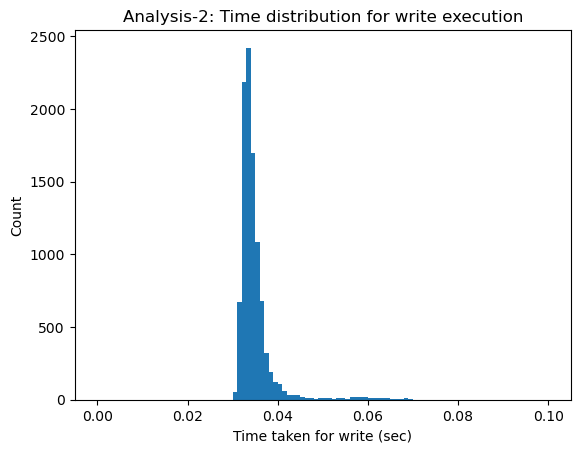

In [128]:
plt.hist(write_time, 100, (0,.1))
plt.xlabel("Time taken for write (sec)")
plt.ylabel("Count")
plt.title("Analysis-2: Time distribution for write execution")
plt.savefig("./results/Assign2_A2_Write.jpg")
plt.show()

### Read Operation

In [126]:
# total_start_time=time.time()
# with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
#     read_tasks=[executor.submit(readRequest) for _ in range(num_requests)]
#     concurrent.futures.wait(read_tasks)

# print(f"Total time taken: {time.time() - total_start_time} secs")
read_time = []

for _ in range(num_requests):
    url = "http://10.171.9.221:5000/read"
    low =  random.randint(0,16383)
    read_Json = {"Stud_id" : {"low":low,"high":low+10}}
    start = time.time()
    requestRes = requests.post(url,json=read_Json)
    # print(str(requestRes))
    read_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in Read")

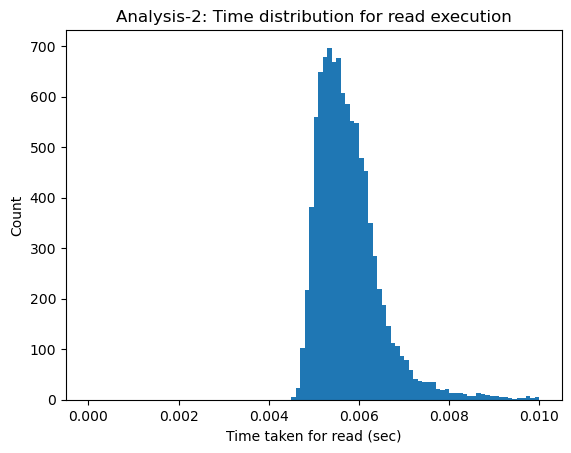

In [130]:
plt.hist(read_time, 100, (0,.01))
plt.xlabel("Time taken for read (sec)")
plt.ylabel("Count")
plt.title("Analysis-2: Time distribution for read execution")
plt.savefig("./results/Assign2_A2_Read.jpg")
plt.show()

In [100]:
# Payload_Json = {
#     "n": 6,
#     "servers": ["Server0", "Server1", "Server2", "Server3", "Server4", "Server5"]
# }

# url = "http://10.171.9.221:5000/rm"
# res = requests.delete(url, json=Payload_Json).json()
# res

{'message': 'Error during removing servers: Sample larger than population or is negative',
 'status': 'error'}

## Analysis 3

In [ ]:
Payload_Json = {
    "N": 10,
    "schema": {
        "columns": ["Stud_id", "Stud_name", "Stud_marks"],
        "dtypes": ["Number", "String", "Number"],
    },
    "shards": [
        {"Stud_id_low": 0, "Shard_id": "sh1", "Shard_size": 4096},
        {"Stud_id_low": 4096, "Shard_id": "sh2", "Shard_size": 4096},
        {"Stud_id_low": 8192, "Shard_id": "sh3", "Shard_size": 4096},
        {"Stud_id_low": 12288, "Shard_id": "sh4", "Shard_size": 4096},
        {"Stud_id_low": 16384, "Shard_id": "sh5", "Shard_size": 4096},
        {"Stud_id_low": 20480, "Shard_id": "sh6", "Shard_size": 4096},
    ],
    "servers": {
        "Server0": ["sh1", "sh2", "sh4", "sh6"],
        "Server1": ["sh1", "sh2", "sh3", "sh4", "sh5"],
        "Server2": ["sh1", "sh2", "sh3", "sh5", "sh6"],
        "Server3": ["sh4", "sh2", "sh3", "sh5", "sh6"],
        "Server4": ["sh1", "sh4", "sh5", "sh6"],
        "Server5": ["sh3", "sh2", "sh5", "sh6"],
        "Server6": ["sh1", "sh3", "sh4", "sh5", "sh6"],
        "Server7": ["sh1", "sh3", "sh4", "sh2", "sh5"],
        "Server8": ["sh1", "sh2", "sh3", "sh4", "sh6"],
        "Server9": ["sh1", "sh2", "sh3", "sh4", "sh5", "sh6"],
    },
}

init_start = time.perf_counter()
res = requests.post("http://10.171.9.221:5000/init",json=Payload_Json).json()
print(res)
init_time = time.perf_counter()-init_start
print("Request completed in {0:.4f} seconds".format(init_time))

In [ ]:
######## Check Status ################
res = requests.get("http://10.171.9.221:5000/status").json()
res

In [ ]:
write_time = []
def writeRequest(id):
    url = "http://10.171.9.221:5000/write"
    write_Json = {"data":[{"Stud_id":id,"Stud_name":f"{str(generate_random_string())}","Stud_marks":random.randint(0,100)}]}
    start = time.time()
    requestRes = requests.post(url,json=write_Json)
    write_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in write")
        
# read_time = []

# def readRequest():
#     url = "http://10.171.9.221:5000/read"
#     low =  random.randint(0,16383)
#     read_Json = {"Stud_id" : {"low":low,"high":low+100}}
#     start = time.time()
#     requestRes = requests.post(url,json=read_Json)
#     read_time.append(time.time() - start)
#     if requestRes.status_code != 200:
#         print(f"Error {requestRes.status_code} in write")

### Write Operation

In [ ]:
total_start_time=time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    write_tasks=[executor.submit(writeRequest(_)) for _ in range(num_requests)]
    concurrent.futures.wait(write_tasks)

print(f"Total time taken: {time.time() - total_start_time} secs")

In [ ]:
plt.hist(write_time, 100, (0,.1))
plt.xlabel("Time taken for write (sec)")
plt.ylabel("Count")
plt.title("Analysis-3: Time distribution for write execution")
plt.savefig("./results/Assign2_A3_Write.jpg")
plt.show()

### Read Operation

In [ ]:
# total_start_time=time.time()
# with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
#     read_tasks=[executor.submit(readRequest) for _ in range(num_requests)]
#     concurrent.futures.wait(read_tasks)

# print(f"Total time taken: {time.time() - total_start_time} secs")

read_time = []

for _ in range(num_requests):
    url = "http://10.171.9.221:5000/read"
    low =  random.randint(0,16383)
    read_Json = {"Stud_id" : {"low":low,"high":low+10}}
    start = time.time()
    requestRes = requests.post(url,json=read_Json)
    # print(str(requestRes))
    read_time.append(time.time() - start)
    if requestRes.status_code != 200:
        print(f"Error {requestRes.status_code} in Read")

In [ ]:
plt.hist(read_time, 100, (0,.01))
plt.xlabel("Time taken for read (sec)")
plt.ylabel("Count")
plt.title("Analysis-3: Time distribution for read execution")
plt.savefig("./results/Assign2_A3_Read.jpg")
plt.show()